In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# load the CSV
file_path = '/content/drive/MyDrive/uber-raw-data-janjune-15.csv'
import pandas as pd
df = pd.read_csv(file_path)
df.head()



Mounted at /content/drive


,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


from matplotlib import pyplot as plt
_df_0['locationID'].plot(kind='hist', bins=20, title='locationID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Affiliated_base_num').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Pickup_date']
  ys = series['locationID']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('Pickup_date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Affiliated_base_num')):
  _plot_series(series, series_name, i)
  fig.legend(title='Affiliated_base_num', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Pickup_date')
_ = plt.ylabel('locationID')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Pickup_date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Pickup_date'}, axis=1)
              .sort_values('Pickup_date', ascending=True))
  xs = counted['Pickup_date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Pickup_date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Affiliated_base_num')):
  _plot_series(series, series_name, i)
  fig.legend(title='Affiliated_base_num', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Pickup_date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_4['locationID'].plot(kind='line', figsize=(8, 4), title='locationID')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['Affiliated_base_num'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='locationID', y='Affiliated_base_num', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<Axes: title={'center': 'Trips by Weekday'}, xlabel='Weekday'>

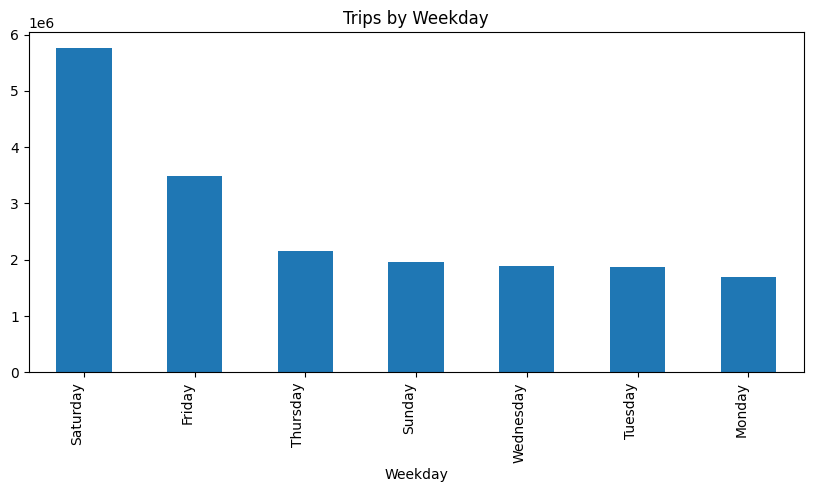

In [ ]:
# 🚀 Convert date column to datetime
df['Pickup_date'] = pd.to_datetime(df['Pickup_date'])

# 🚀 Add extra time features
df['Weekday'] = df['Pickup_date'].dt.day_name()
df['Month'] = df['Pickup_date'].dt.month_name()

# 🚀 Trips per day
trips_per_day = df.groupby('Pickup_date').size()
trips_per_day.plot(title='Trips per Day', figsize=(12, 5))

# 🚀 Trips by base
df['Dispatching_base_num'].value_counts().plot(kind='bar', title='Trips by Dispatching Base', figsize=(10,5))

# 🚀 Trips by location
df['locationID'].value_counts().head(10).plot(kind='bar', title='Top 10 Pickup Locations', figsize=(10,5))

# 🚀 Trips by weekday
df['Weekday'].value_counts().plot(kind='bar', title='Trips by Weekday', figsize=(10,5))


In [ ]:
# 0. Install any dependencies
!pip install xgboost --quiet

Mounted at /content/drive


<ipython-input-11-524e929070fc>:15: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(file_path, parse_dates=['Pickup_date'], infer_datetime_format=True)


Raw data shape: (14270479, 4)
Hourly data shape: (4344, 2)
After lagging, shape: (4320, 30)

MAPE Results:
  Random Forest     MAPE: 6.95%
  Gradient Boosting MAPE: 8.15%
  XGBoost           MAPE: 6.79%
  Ensemble          MAPE: 6.93%


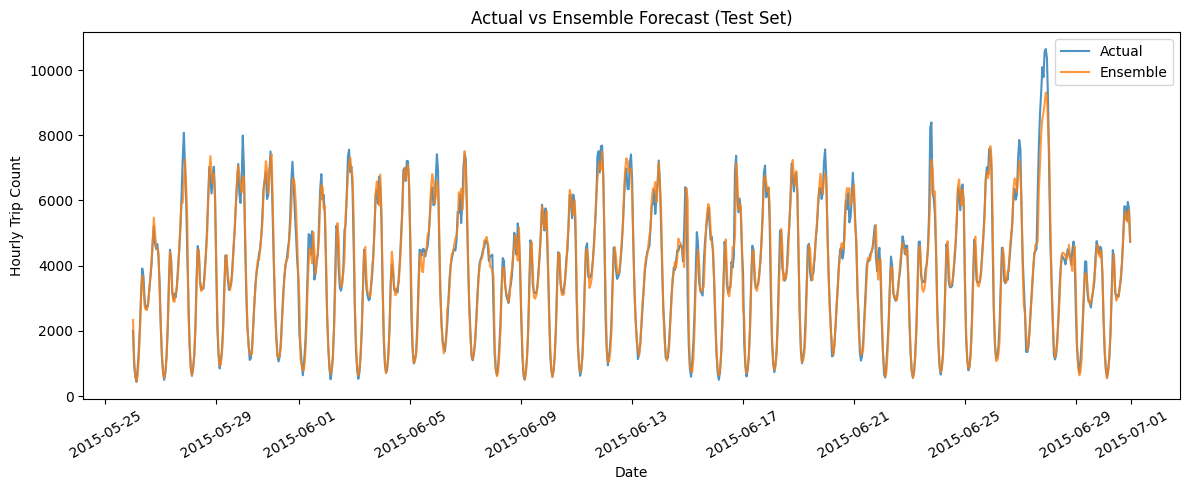

In [ ]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 2. Mount Google Drive and load data
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

file_path = '/content/drive/MyDrive/uber-raw-data-janjune-15.csv'  # adjust as needed
df = pd.read_csv(file_path, parse_dates=['Pickup_date'], infer_datetime_format=True)
print("Raw data shape:", df.shape)
df.head()

# 3. Aggregate to hourly trip counts (fixed)
#    ensure Pickup_date is datetime, set as index, then resample with 'h'
df = df.set_index('Pickup_date')
hourly = (
    df
    .resample('h')                     # lowercase 'h' to avoid FutureWarning
    .size()                            # count rows per hour
    .to_frame(name='trip_count')      # make DataFrame with column 'trip_count'
    .reset_index()                     # bring 'Pickup_date' back as a column
)
print("Hourly data shape:", hourly.shape)
hourly.head()

# 4. Feature engineering
hourly['hour']       = hourly['Pickup_date'].dt.hour
hourly['dayofweek']  = hourly['Pickup_date'].dt.dayofweek
hourly['month']      = hourly['Pickup_date'].dt.month
hourly['is_weekend'] = (hourly['dayofweek'] >= 5).astype(int)

# 4.2 Lag features: last 24 hours
for lag in range(1, 25):
    hourly[f'lag_{lag}'] = hourly['trip_count'].shift(lag)

# 4.3 Drop the first 24 rows with NaNs from lagging
hourly = hourly.dropna().reset_index(drop=True)
print("After lagging, shape:", hourly.shape)

# 5. Train/test split (time series, no shuffle)
cutoff = int(len(hourly) * 0.8)
train = hourly.iloc[:cutoff]
test  = hourly.iloc[cutoff:]

X_train = train.drop(['Pickup_date','trip_count'], axis=1)
y_train = train['trip_count']
X_test  = test.drop(['Pickup_date','trip_count'], axis=1)
y_test  = test['trip_count']

# 6. Fit individual models
rf  = RandomForestRegressor(n_estimators=200, random_state=42)
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1,
                   objective='reg:squarederror', random_state=42)

rf .fit(X_train, y_train)
gbr.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# 7. Make predictions
rf_preds  = rf .predict(X_test)
gbr_preds = gbr.predict(X_test)
xgb_preds = xgb.predict(X_test)

# 8. Simple ensemble: average of the three
ensemble_preds = (rf_preds + gbr_preds + xgb_preds) / 3

# 9. Evaluate
print("\nMAPE Results:")
for name, preds in [
    ('Random Forest', rf_preds),
    ('Gradient Boosting', gbr_preds),
    ('XGBoost', xgb_preds),
    ('Ensemble', ensemble_preds)
]:
    mape = mean_absolute_percentage_error(y_test, preds)
    print(f'  {name:17s} MAPE: {mape:.2%}')

# 10. Plot Test vs Ensemble
plt.figure(figsize=(12,5))
plt.plot(test['Pickup_date'], y_test,  label='Actual', alpha=0.8)
plt.plot(test['Pickup_date'], ensemble_preds, label='Ensemble', alpha=0.8)
plt.legend(), plt.xlabel('Date'), plt.ylabel('Hourly Trip Count')
plt.title('Actual vs Ensemble Forecast (Test Set)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [ ]:
# Complete Colab Pipeline: Hyperparameter Tuning, Feature Engineering, Next‑Hour Forecast & Dashboard

# 0. Install needed library
!pip install xgboost plotly --quiet

# 1. Imports
import pandas as pd
import numpy as np
import plotly.graph_objects as go

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# 2. Load & aggregate raw Jan–June 2015 data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

file_path = '/content/drive/MyDrive/uber-raw-data-janjune-15.csv'
df = pd.read_csv(file_path, parse_dates=['Pickup_date'])
df.set_index('Pickup_date', inplace=True)

# Aggregate into hourly trip counts
hourly = df.resample('h').size().to_frame('trip_count')

# 3. Feature Engineering
# 3.1 Time‑based features
hourly['hour']       = hourly.index.hour
hourly['dayofweek']  = hourly.index.dayofweek
hourly['month']      = hourly.index.month
hourly['is_weekend'] = (hourly['dayofweek'] >= 5).astype(int)

# 3.2 Rolling statistics (past 24h)
hourly['roll_mean_24h'] = hourly['trip_count'].rolling(24).mean()
hourly['roll_std_24h']  = hourly['trip_count'].rolling(24).std()

# 3.3 Lag features (last 24 hours)
for lag in range(1, 25):
    hourly[f'lag_{lag}'] = hourly['trip_count'].shift(lag)

# Drop initial rows with NaNs
hourly.dropna(inplace=True)

# 4. Train/Test split (80/20 time series)
cutoff = int(len(hourly) * 0.8)
train = hourly.iloc[:cutoff]
test  = hourly.iloc[cutoff:]

X_train = train.drop('trip_count', axis=1)
y_train = train['trip_count']
X_test  = test.drop('trip_count', axis=1)
y_test  = test['trip_count']

# 5. Hyperparameter Tuning & Model Training
tscv = TimeSeriesSplit(n_splits=5)

models_cfg = {
    'XGB': XGBRegressor(objective='reg:squarederror', random_state=42),
    'RF':  RandomForestRegressor(random_state=42),
    'GBR': GradientBoostingRegressor(random_state=42)
}

params_dist = {
    'XGB': {
        'n_estimators': [100,200,300],
        'max_depth':    [3,6,9],
        'learning_rate':[0.01,0.1],
        'subsample':    [0.8,1.0],
        'colsample_bytree':[0.8,1.0]
    },
    'RF': {
        'n_estimators': [100,200,300],
        'max_depth':    [10,20,30],
        'min_samples_split':[2,5],
        'min_samples_leaf':[1,2]
    },
    'GBR': {
        'n_estimators': [100,200,300],
        'learning_rate':[0.01,0.1],
        'max_depth':    [3,5],
        'min_samples_split':[2,5],
        'min_samples_leaf':[1,2]
    }
}

fitted_models = {}
for name, model in models_cfg.items():
    search = RandomizedSearchCV(
        model,
        params_dist[name],
        n_iter=20,
        cv=tscv,
        scoring='neg_mean_absolute_percentage_error',
        n_jobs=-1,
        verbose=0,
        random_state=42
    )
    search.fit(X_train, y_train)
    print(f"Best params for {name}:", search.best_params_)
    fitted_models[name] = search.best_estimator_

# 6. Predictions on Test
preds = {name: m.predict(X_test) for name, m in fitted_models.items()}

# 7. Ensemble Weights (using inverse MAPE)
mapes = {name: mean_absolute_percentage_error(y_test, p) for name, p in preds.items()}
inv   = {name: 1/mapes[name] for name in mapes}
total = sum(inv.values())
weights = {name: inv[name]/total for name in inv}
ensemble_preds = sum(preds[name] * weights[name] for name in preds)

print("Ensemble weights:", weights)

# 8. Evaluation Metrics Function (includes RMSE via sqrt)
def print_metrics(prefix, y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    print(f"{prefix:17s} | MAPE: {mape:.2%} | RMSE: {rmse:.2f} | R2: {r2:.3f}")

print("\n--- TRAIN SET METRICS ---")
for name, m in fitted_models.items():
    print_metrics(f"{name} (train)", y_train, m.predict(X_train))
print_metrics("Ensemble (train)", y_train,
              sum(fitted_models[n].predict(X_train) * weights[n] for n in fitted_models))

print("\n--- TEST SET METRICS ---")
for name, p in preds.items():
    print_metrics(f"{name} (test)", y_test, p)
print_metrics("Ensemble (test)", y_test, ensemble_preds)

# 9. Next‑Hour Forecast Loop
def forecast_hours(history_df, models, weights, N=24):
    df = history_df[['trip_count']].copy()
    forecasts = []
    for _ in range(N):
        t = df.index[-1] + pd.Timedelta(hours=1)
        feat = {
            'hour':         t.hour,
            'dayofweek':    t.dayofweek,
            'month':        t.month,
            'is_weekend':   int(t.dayofweek >= 5),
            'roll_mean_24h': df['trip_count'][-24:].mean(),
            'roll_std_24h':  df['trip_count'][-24:].std()
        }
        for lag in range(1,25):
            feat[f'lag_{lag}'] = df['trip_count'].iloc[-lag]
        Xn = pd.DataFrame(feat, index=[t])
        model_preds = {n: m.predict(Xn)[0] for n,m in models.items()}
        ens = sum(model_preds[n] * weights[n] for n in model_preds)
        df.loc[t, 'trip_count'] = ens
        forecasts.append((t, ens))
    return pd.DataFrame(forecasts, columns=['datetime','forecast']).set_index('datetime')

future_df = forecast_hours(hourly, fitted_models, weights, N=24)

# 10. Interactive Dashboard with Plotly
fig = go.Figure()
# Actual vs Test
fig.add_trace(go.Scatter(x=test.index, y=y_test, mode='lines', name='Actual'))
# Model Traces
for name, p in preds.items():
    fig.add_trace(go.Scatter(x=test.index, y=p, mode='lines', name=name))
# Ensemble Trace
fig.add_trace(go.Scatter(x=test.index, y=ensemble_preds,
                         mode='lines', name='Ensemble', line=dict(width=4)))
# Future Forecast
fig.add_trace(go.Scatter(x=future_df.index, y=future_df['forecast'],
                         mode='lines', name='24h Forecast', line=dict(dash='dash')))

fig.update_layout(
    title="Uber Hourly Trips: Actual vs Predictions & 24‑Hour Forecast",
    xaxis_title="Datetime",
    yaxis_title="Trip Count",
    legend_title="Legend",
    template="plotly_white",
    height=600
)
fig.show()



Mounted at /content/drive
Best params for XGB: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best params for RF: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20}
Best params for GBR: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.1}
Ensemble weights: {'XGB': 0.34793705920893986, 'RF': 0.32484226081699513, 'GBR': 0.32722067997406495}

--- TRAIN SET METRICS ---
XGB (train)       | MAPE: 93719353937100800.00% | RMSE: 67.25 | R2: 0.999
RF (train)        | MAPE: 547474161983981568.00% | RMSE: 143.57 | R2: 0.993
GBR (train)       | MAPE: 140627053887556848.00% | RMSE: 95.80 | R2: 0.997
Ensemble (train)  | MAPE: 253001510991601536.00% | RMSE: 90.42 | R2: 0.997

--- TEST SET METRICS ---
XGB (test)        | MAPE: 6.75% | RMSE: 384.04 | R2: 0.960
RF (test)         | MAPE: 7.22% | RMSE: 388.87 | R2: 0.959
GBR (test)        | MAPE: 7.17% | RMSE: 379

In [ ]:
import joblib

# Save models and weights
joblib.dump(fitted_models['XGB'], 'xgb_model.pkl')
joblib.dump(fitted_models['RF'], 'rf_model.pkl')
joblib.dump(fitted_models['GBR'], 'gbr_model.pkl')
joblib.dump(weights, 'ensemble_weights.pkl')

['ensemble_weights.pkl']

In [ ]:
files.download('xgb_model.pkl')
files.download('rf_model.pkl')
files.download('gbr_model.pkl')
files.download('ensemble_weights.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>